In [1]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import data_preparation 
from p_drought_indices.analysis.DeepLearning.pipeline_convlstm import training_lstm
import pickle
import os
import matplotlib.pyplot as plt
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_split, interpolate_prepare
import numpy as np
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader

CONFIG_PATH = "../config.yaml"
sub_precp, ds = data_preparation(CONFIG_PATH)
sub_precp = sub_precp.to_dataset()
data, target = interpolate_prepare(sub_precp, ds)
train_split = 0.8
training_lstm(CONFIG_PATH, data, target, train_split = train_split)

c:\Users\Riccardo\anaconda3\envs\gis2_py39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


The ERA5 raster has spatial dimensions: (0.10000000419197502, -0.1000000004915847)
NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
Precipitation dataset resolution (0.10000000419197502, -0.1000000004915847)


In [1]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import data_preparation, get_dataloader, main
from p_drought_indices.analysis.DeepLearning.pipeline_convlstm import training_lstm
import pickle
import os
import matplotlib.pyplot as plt
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_split, interpolate_prepare, subsetting_pipeline, get_lat_lon_window
import numpy as np
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import xarray as xr


CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)

c:\Users\Riccardo\anaconda3\envs\gis2_py39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
sub_precp, ds = data_preparation(CONFIG_PATH)

The ERA5 raster has spatial dimensions: (0.10000000419197502, -0.1000000004915847)
NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
Precipitation dataset resolution (0.10000000419197502, -0.1000000004915847)


In [6]:
dataloader, num_nodes = get_dataloader(CONFIG_PATH, sub_precp, ds)

The features have dimensions: (122, 184, 1)
The instance have dimensions: (122, 184, 1)
x shape:  (99, 12, 184, 1) , y shape:  (99, 12, 184, 1)
train x:  (85, 12, 184, 1) y: (85, 12, 184, 1)
val x:  (13, 12, 184, 1) y: (13, 12, 184, 1)
test x:  (24, 12, 184, 1) y: (24, 12, 184, 1)


The ERA5 raster has spatial dimensions: (0.10000000419197502, -0.1000000004915847)
NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
Precipitation dataset resolution (0.10000000419197502, -0.1000000004915847)
Checking precipitation dataset...
lat-axis values: [14.8 14.7 14.6 14.5 14.4 14.3 14.2 14.1 14.  13.9 13.8 13.7 13.6 13.5
 13.4 13.3 13.2 13.1 13.  12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1
 12.  11.9 11.8 11.7]
lon-axis values: [33.1 33.2 33.3 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4
 34.5 34.6 34.7 34.8 34.9 35.  35.1 35.2 35.3 35.4 35.5 35.6 35.7 35.8
 35.9 36.  36.1 36.2]
Dimensions: ('time', 'lat', 'lon')
Size: 124928
Number of Dimensions: 3
Coordinates: Coordinates:
  * lon          (lon) float32 33.1 33.2 33.3 33.4 33.5 ... 35.9 36.0 36.1 36.2
  * lat          (lat) float32 14.8 14.7 14.6 14.5 14.4 ... 12.0 11.9 11.8 11.7
  * time         (time) datetime64[ns] 2019-09-01 2019-09-02 ... 2019-12-31
    spatial_ref  int32 0
    crs          

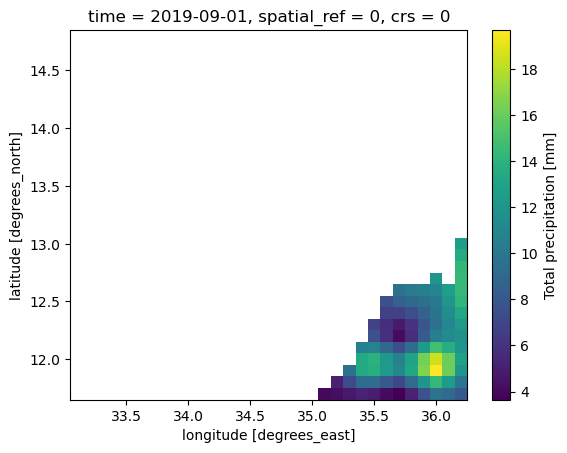

Checking vegetation dataset
lat-axis values: [14.8 14.7 14.6 14.5 14.4 14.3 14.2 14.1 14.  13.9 13.8 13.7 13.6 13.5
 13.4 13.3 13.2 13.1 13.  12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1
 12.  11.9 11.8 11.7]
lon-axis values: [33.1 33.2 33.3 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4
 34.5 34.6 34.7 34.8 34.9 35.  35.1 35.2 35.3 35.4 35.5 35.6 35.7 35.8
 35.9 36.  36.1 36.2]
Dimensions: ('time', 'lat', 'lon')
Size: 124928
Number of Dimensions: 3
Coordinates: Coordinates:
  * lon          (lon) float32 33.1 33.2 33.3 33.4 33.5 ... 35.9 36.0 36.1 36.2
  * lat          (lat) float32 14.8 14.7 14.6 14.5 14.4 ... 12.0 11.9 11.8 11.7
    crs          int64 0
  * time         (time) datetime64[ns] 2019-09-01 2019-09-02 ... 2019-12-31
    spatial_ref  int32 0
Is null: <xarray.DataArray 'ndvi' ()>
array(113704)
Coordinates:
    crs          int64 0
    spatial_ref  int32 0
Not null: <xarray.DataArray 'ndvi' ()>
array(11224)
Coordinates:
    crs          int64 0
    spatial_ref  int3

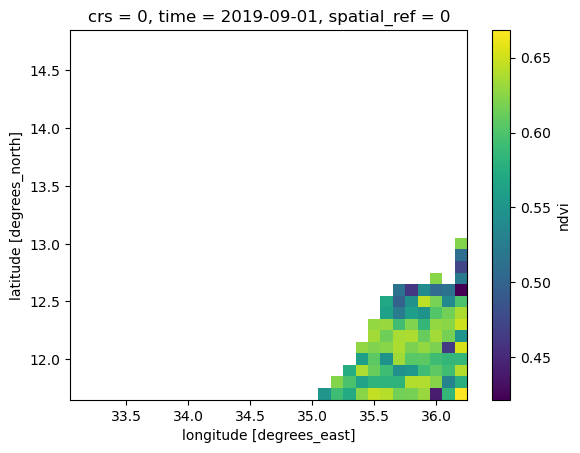

The features have dimensions: (122, 184, 1)
The instance have dimensions: (122, 184, 1)
x shape:  (99, 12, 184, 1) , y shape:  (99, 12, 184, 1)
train x:  (85, 12, 184, 1) y: (85, 12, 184, 1)
val x:  (13, 12, 184, 1) y: (13, 12, 184, 1)
test x:  (24, 12, 184, 1) y: (24, 12, 184, 1)


NameError: name 'args' is not defined

In [2]:
device ='cpu'
seq_length=12
nhid=32
in_dim =1
adjtype = "doubletransition"
learning_rate=0.001
dropout=0.3
weight_decay=0.0001
gcn_bool = "store_true"
addaptadj = "store_true"
print_every = 50

main(CONFIG_PATH)

In [71]:
def data_CHECK(data_array:xr.DataArray):
    # Check shape and size
    print("Shape:", data_array.shape)
    print("Size:", data_array.size)
    
    # Check coordinates and dimensions
    print("Dimensions:", data_array.dims)
    print("Coordinates:", data_array.coords)
    
    # Check data type and values
    print("Data Type:", data_array.dtype)
    print("Data Values:", data_array.values)
    
    # Check for missing values
    print("Missing Values:", data_array.isnull().any())
    
    # Check attributes
    print("Attributes:", data_array.attrs)

In [99]:
time_end = config['DEFAULT']['date_end']
time_start = config['DEFAULT']['date_start']
dataset = prepare(xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))).sel(time=slice(time_start,time_end))[["time","lat","lon","ndvi"]]

In [100]:
path = config['SPI']['ERA5']['path']
dim = config["GWNET"]["pixels"]
file = "era5_land_merged.nc" #f"ERA5_spi_gamma_{late}.nc"
precp_ds = prepare(subsetting_pipeline(CONFIG_PATH, xr.open_dataset(os.path.join(path, file))))
var_target = [var for var in precp_ds.data_vars][0]

idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(precp_ds, dim)
sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))\
    .sel(lat=slice(lat_max, idx_lat), lon=slice(lon_min, idx_lon))
ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})
sub_precp = sub_precp[var_target].where(ds.notnull())